<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ML_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
!pip install -U scikit_learn

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [35]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



In [36]:
df = pd.read_csv("perrin-freres-monthly-champagne.csv",index_col = "Month",skipfooter = 2,parse_dates = True)

<ipython-input-36-e811c7e6f3f2>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("perrin-freres-monthly-champagne.csv",index_col = "Month",skipfooter = 2,parse_dates = True)


In [37]:
df.columns

Index(['Perrin Freres monthly champagne sales millions ?64-?72'], dtype='object')

In [38]:
df.columns = ['Sales']

In [39]:
df['LogSales'] = np.log(df['Sales'])

In [40]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [41]:
#Make supervised dataset
#use past value to predict next value
series = df['LogSales'].to_numpy()

T = 12
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print("X.shape: ",X.shape," Y.shape: ",Y.shape)

X.shape:  (93, 12)  Y.shape:  (93,)


In [42]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [43]:
lr = LinearRegression()
lr.fit(XTrain,YTrain)
lr.score(XTrain,YTrain)

0.8682372095558999

In [44]:
lr.score(XTest,YTest)

0.9657520752272787

In [53]:
#Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

#First T values are not predictable
train_idx[:T] = False

In [54]:
#1 step forecast
df.loc[train_idx,'LR_1step_train'] = lr.predict(XTrain)
df.loc[test_idx,'LR_1step_test'] = lr.predict(XTest)

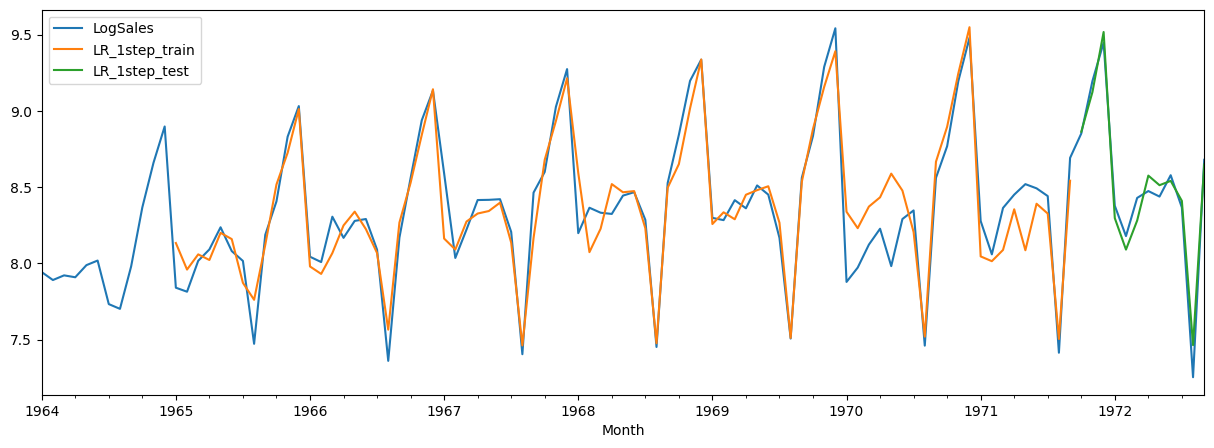

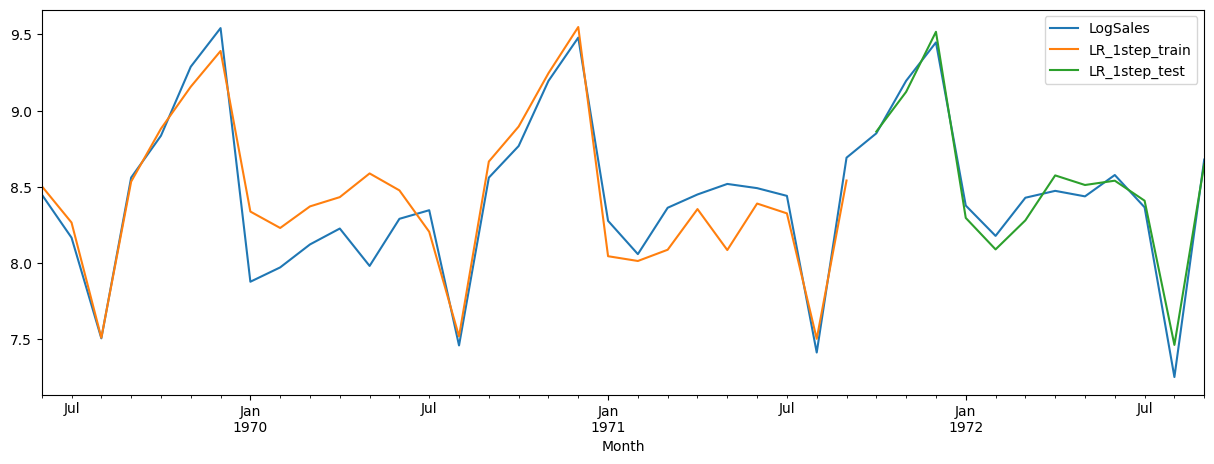

In [58]:
col = [
    'LogSales',
    'LR_1step_train',
    'LR_1step_test'
]
df[col].plot(figsize = (15,5))
df.iloc[-40:][col].plot(figsize = (15,5));

In [59]:
#multi-step forecast
multistep_predictions = []

#first test input
last_x = XTest[0]

while len(multistep_predictions) < NTest:
  p = lr.predict(last_x.reshape(1,-1))[0]

  #update the predictions list
  multistep_predictions.append(p)

  last_x = np.roll(last_x,-1)
  last_x[-1] = p

In [69]:
#Save multi-step forecast to dataframe
df.loc[test_idx,'LR_multistep'] = multistep_predictions

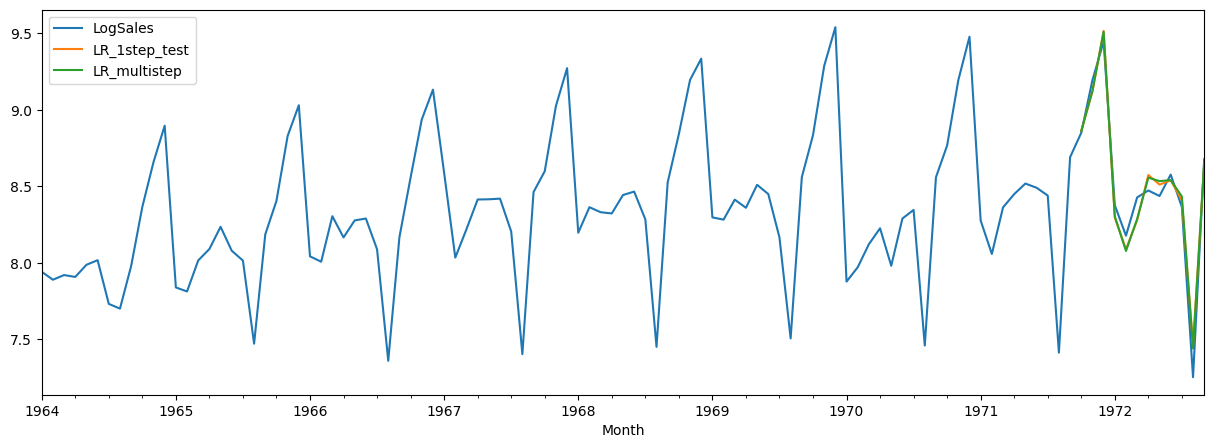

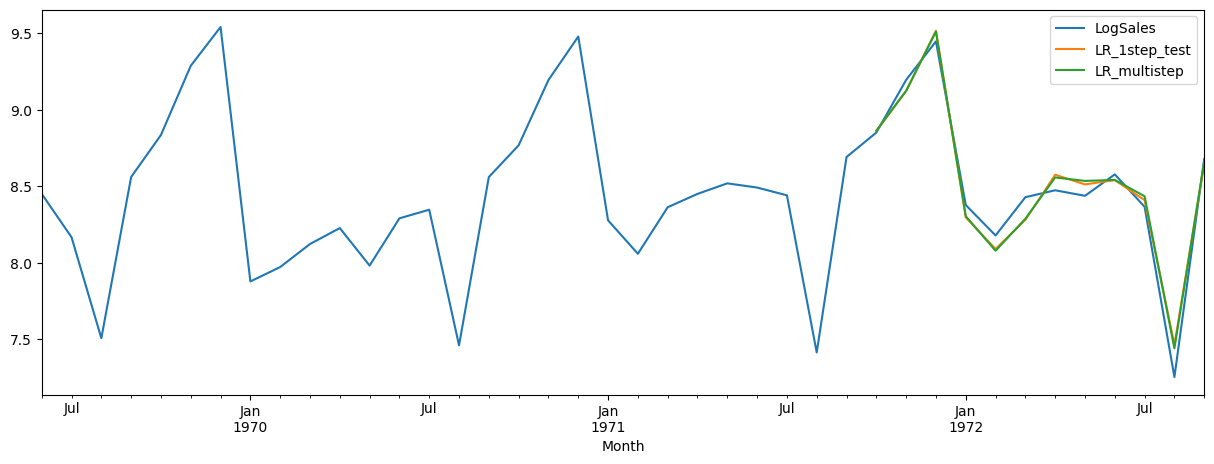

In [70]:
#Plot 1-step and multi-step forecast
col = [
    'LogSales',
    'LR_1step_test',
    'LR_multistep'
]
df[col].plot(figsize = (15,5))
df.iloc[-40:][col].plot(figsize = (15,5));

In [95]:
#Make multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)


X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

print("X.shape: ",X.shape," Y.shape: ",Y.shape)

X.shape:  (82, 12)  Y.shape:  (82, 12)


In [98]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [101]:
lr = LinearRegression()
lr.fit(XTrain_m,YTrain_m)
lr.score(XTrain_m,YTrain_m)

0.8829262390390559

In [102]:
r2_score(lr.predict(XTest_m).flatten(),YTest_m.flatten())

0.9595107879158425

In [103]:
#Save multi-output forecast to dataframe
df.loc[test_idx,'LR_multioutput'] = lr.predict(XTest_m).flatten()

<Axes: xlabel='Month'>

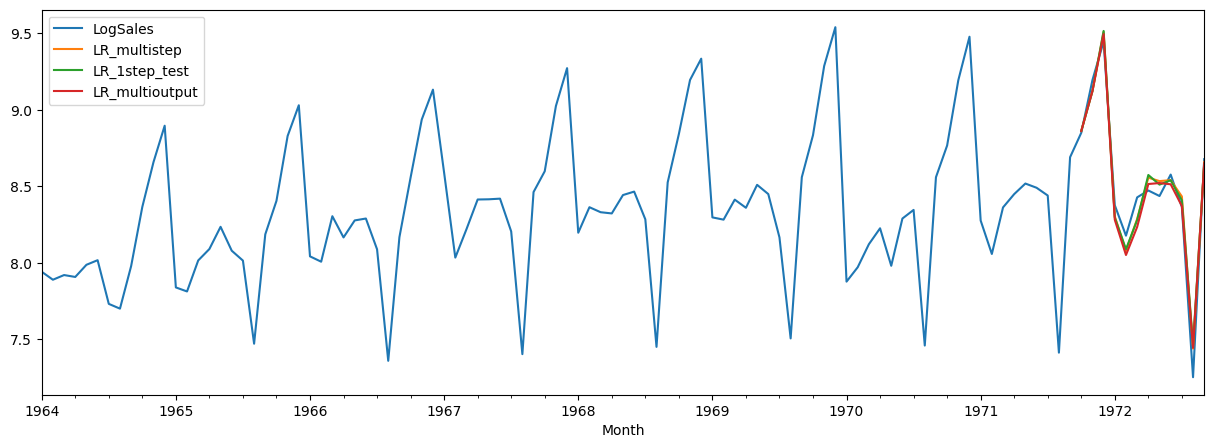

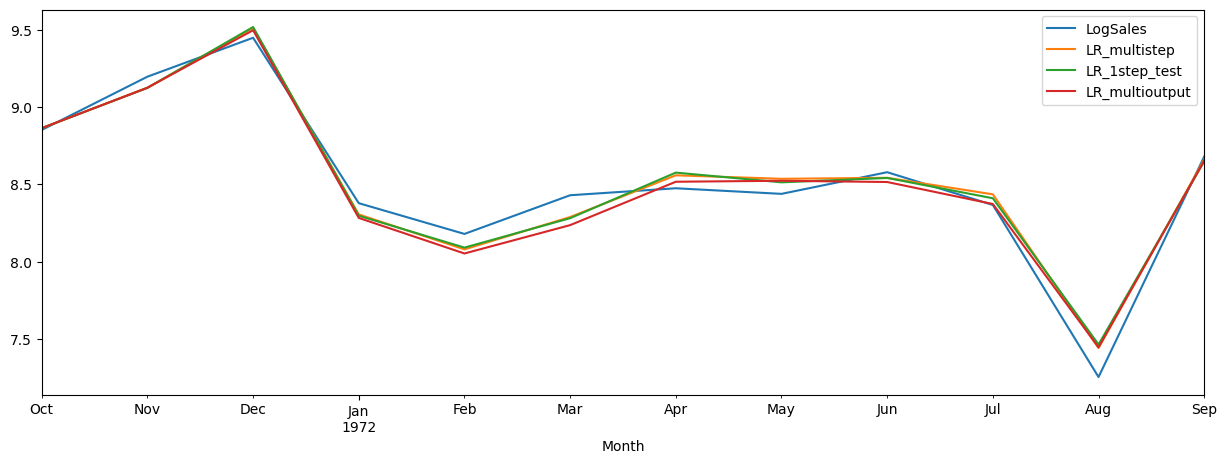

In [106]:
#Plot all the forecast
col = [
    'LogSales',
    'LR_multistep',
    'LR_1step_test',
    'LR_multioutput'
]
df[col].plot(figsize = (15,5))
df.iloc[-12:][col].plot(figsize = (15,5))

In [109]:
#MAPE
mape1 = mean_absolute_percentage_error(YTest,multistep_predictions)
print("Multi-step   MAPE: ",mape1)
mape2 = mean_absolute_percentage_error(YTest_m.flatten(),df.loc[test_idx,'LR_multioutput'])
print("Multi-output MAPE: ",mape2)

Multi-step   MAPE:  0.009607169373797667
Multi-output MAPE:  0.009727020853255903


# **Test Other Model**

In [122]:
def one_step_and_multistep_forecast(model,name):
  model.fit(XTrain,YTrain)
  print('One-step forecast: ',name)

  #Store 1-step forecast
  df.loc[train_idx,f"{name}_1step_train"] = model.predict(XTrain)
  df.loc[test_idx,f"{name}_1step_test"] = model.predict(XTest)

  #Generate multistep forecast
  multistep_predictions = []

  x_last = XTest[0]

  while len(multistep_predictions) < NTest:
    p = model.predict(x_last.reshape(1,-1))[0]
    multistep_predictions.append(p)

    x_last = np.roll(x_last,-1)
    x_last[-1] = p

  #Store multistep forecast
  df.loc[test_idx,f"{name}_multistep_test"] = multistep_predictions
  #MAPE for multi-step forecast
  mape = mean_absolute_percentage_error(YTest,multistep_predictions)
  print("Test MAPE (multi-step): ",mape)

  cols = [
    'LogSales',
    f"{name}_1step_train",
    f"{name}_1step_test",
    f"{name}_multistep_test"
  ]

  df[cols].plot(figsize = (15,5))
  df.iloc[-30:][cols].plot(figsize = (15,5));


One-step forecast:  SVR
Test MAPE (multi-step):  0.013188370472848127


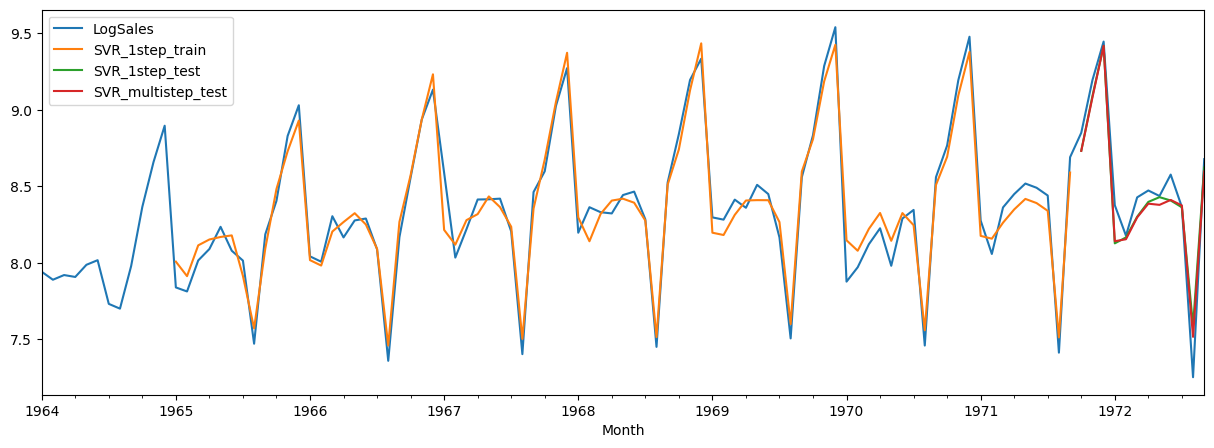

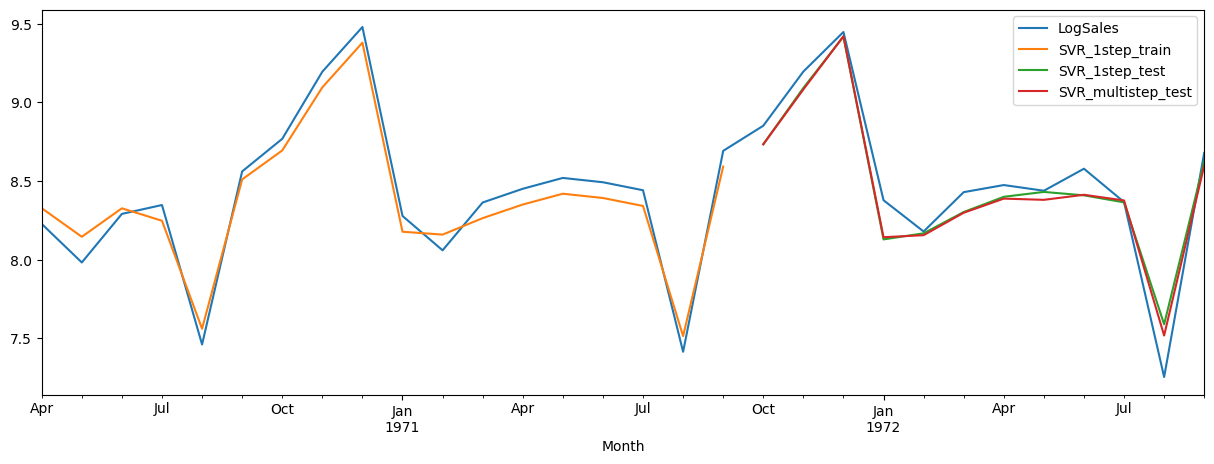

In [123]:
one_step_and_multistep_forecast(SVR(),"SVR")

One-step forecast:  RF
Test MAPE (multi-step):  0.011228603044834666


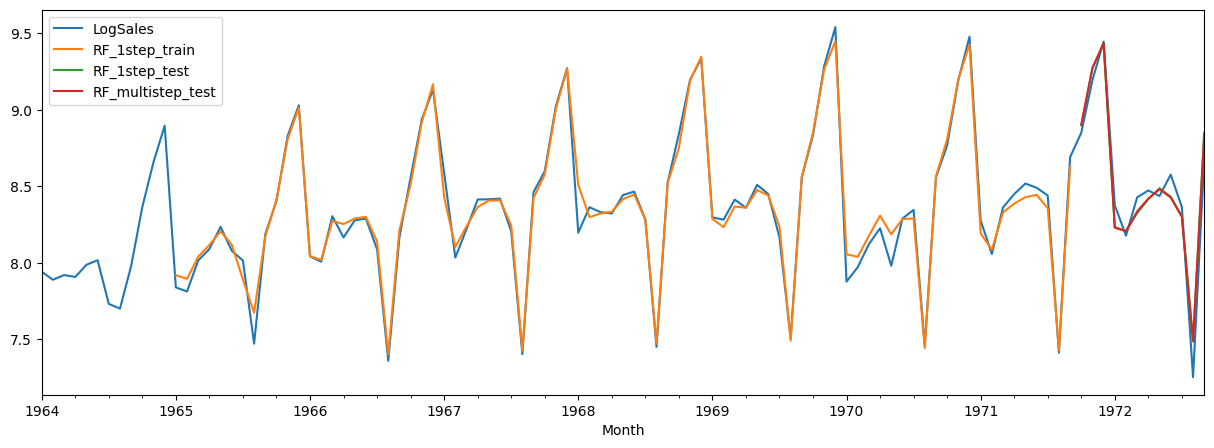

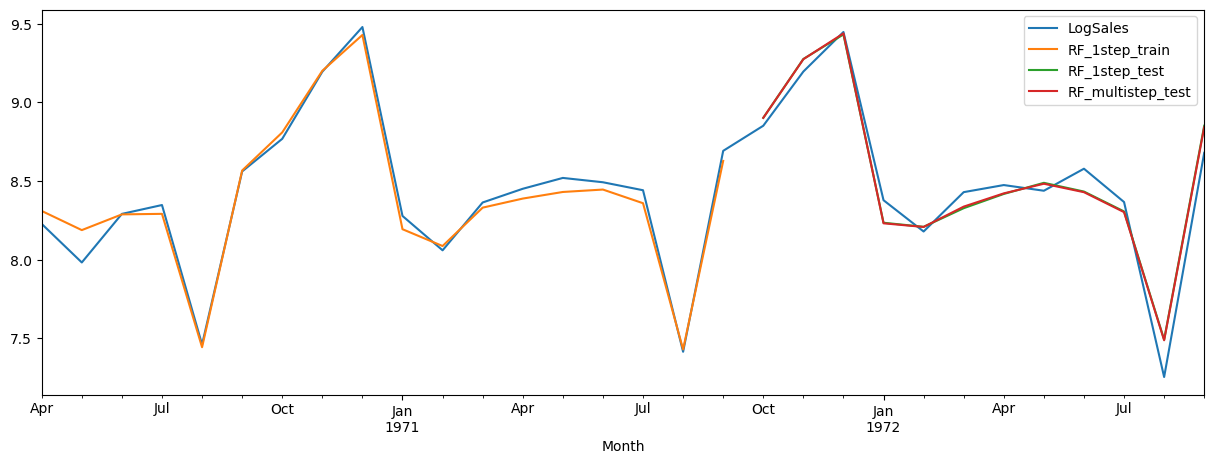

In [124]:
one_step_and_multistep_forecast(RandomForestRegressor(),"RF")

In [133]:
def multioutput_forecast(model,name):
  model.fit(XTrain_m,YTrain_m)

  #Save multi-output forecast to dataframe
  df.loc[test_idx,f"{name}_multioutput"] = model.predict(XTest_m).flatten()

  mape = mean_absolute_percentage_error(YTest_m.flatten(),df.loc[test_idx,f"{name}_multioutput"])
  print("Test MAPE (multi-output) : ",mape)

  #Plot all the forecast
  cols = [
      'LogSales',
      f"{name}_1step_test",
      f"{name}_multistep_test",
      f"{name}_multioutput"
  ]

  df[cols].plot(figsize = (15,5))
  df.iloc[-40:][cols].plot(figsize = (15,5));


Test MAPE (multi-output) :  0.01903180188495674


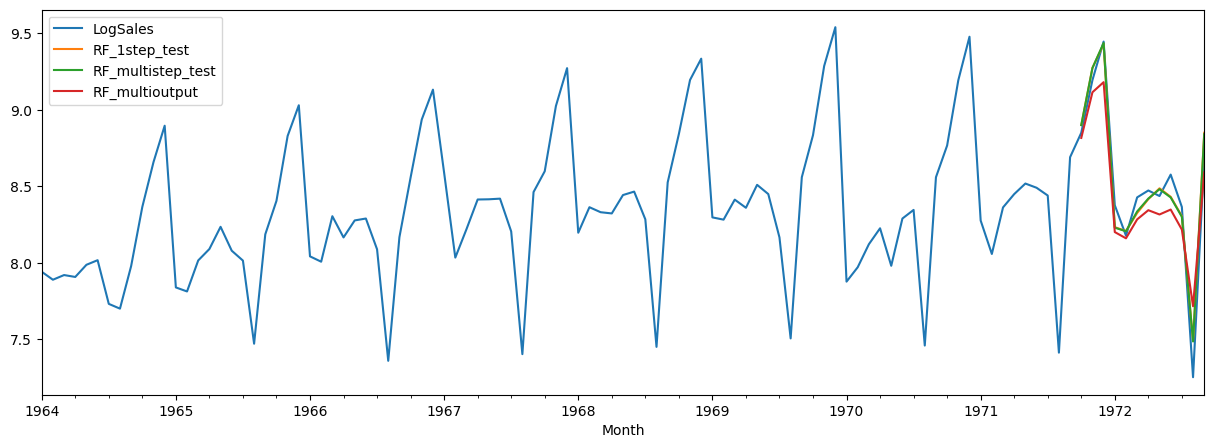

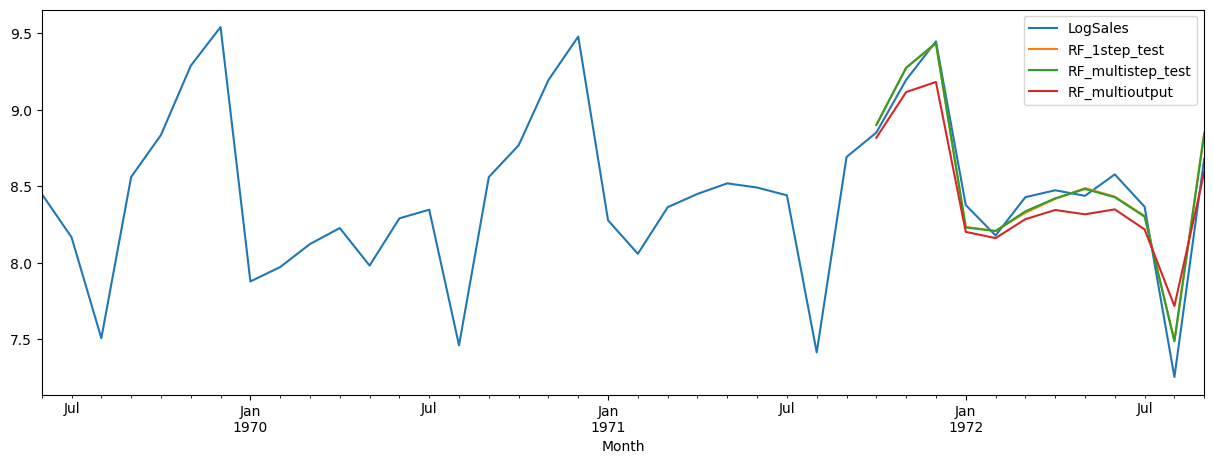

In [134]:
multioutput_forecast(RandomForestRegressor(),"RF")